# DECSKS-26 -- Trigonometric derivatives revisited on a cell-centered perspective


The purpose of this notebook is mainly to verify we can produce accurate derivatives using a Fourier method, and which range of sampling we should use. We need an FFT to see the function as periodic, in previous stepthrough where we had edge-centered gridpoints, this required we not include the the closed endpoint on the periodic interval $[a,b]$ where $f(a) = f(b)$. Now we have $x_i\in (a,b)$, so we have no redundancies, so we anticipate all points should be required for the sampling and will give the best estimate without need to include extra points. This will also let us check the Fourier Gauss law solver</b>. We paste the algorithm from the notebook s05

## (s05) D.1.a. General algorithm

<ol>
<li> Compute the wave number vector $\underline{\xi}$, where the $k$th wave number is given by:
$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$
Note, this computation recognizes that second half of the wave numbers are equal to the negative wave numbers.

<li> Compute the discrete Fourier transform of the charge density $\rho$, e.g. by a fast Fourier transform algorithm,
$${}$$
$$\text{FFT}[\underline{\rho}] = (\text{FFT}[\rho](0), \text{FFT}[\rho](1), \text{FFT}[\rho](2), \ldots , \text{FFT}[\rho](N_x - 1)) = \left(\text{FFT}[\rho](\ell )\right)_{\ell = 0}^{N_x - 1}$$
$${}$$

Note, for our Vlasov-Poisson model case we consider singly charged ions of uniform background density $n_0 = \text{constant}$, and in our normalized units (charges = $\pm 1$) we can calculate $\rho_i = n_0 - \sum_{j = 0}^{N_v - 1} \Delta v_j f^n_{i,j}$, where $f^n_{i,j} = f(t^n, x_i, v_j)$ with velocity space grid spacing $\Delta v_j$.

<li> Find the discrete Fourier transform of the fluctuating field component, $\text{FFT}[\underline{\tilde{E}}]$, from eqs. (2), (3):
$${}$$
$$\text{FFT}[\underline{\tilde{E}}] = \left[0, \left(\frac{\text{FFT}[\rho](\ell )}{\text{i}\xi_k}\right)_{\ell = k = 1}^{N_x - 1}\right]= \left(0, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_0}, \frac{\text{FFT}[\rho](1)}{\text{i}\xi_1}, \frac{\text{FFT}[\rho](2)}{\text{i}\xi_2} , \ldots , \frac{\text{FFT}[\rho](N_x-1)}{\text{i}\xi_{N_x -1}} \right) \qquad (2,3 \text{ revisited})$$
$${}$$
where the $\ell$th component $\text{FFT}[\rho](\ell )$ must correspond to the $k$th Fourier wave number $\xi_k$. If using a library module to compute an FFT, this may require reviewing the associated documentation to understand the organization of returned FFT vectors, so it is understood which vector entry corresponds to which wave number, e.g. in numpy.fft we consult [2] (the wave number vector computed in step (1) is in the same order as the vector returned by numpy.fft.fft)

Note, in NumPy arrays, a vectorized computation of this does not require looping and can be done by numpy division of two arrays.


<li> Find the fluctuating electric field in real space by taking the IFFT of the vector computed in step (3):  per eq. (1)
$${}$$
$$\underline{\tilde{E}}(t^n,\underline{x}) = \text{IFFT}[\text{FFT}[\underline{\tilde{E}}]] \qquad \qquad (1, \text{revisited})$$
$${}$$


<li> The total field is then $\underline{E}(t^n, \underline{x}) = \langle \underline{E}(t^n, \underline{x})\rangle + \underline{\tilde{E}}(t^n,\underline{x})$. For an energy conservative plasma, we have $\langle E \rangle = 0$ so that $E = \tilde{E}$.

</ol>


The following is stored as <code>pyfiles/Gauss.py</code> where the difference now is that <code>Nx</code> is anticipated to be the total number of cell-centers (or cells) hence we do not have Nx-1 anymore but Nx in the calculation for the width dx = L / Nx. This is usual. We also provide inputs for Nx, dx and L (in DECSKS these will be passed with x as attributes since x is a class object). We had previously computed L = max(x) - min(x), but now since x spans the interior of $(a,b)$ we must properly frame the length as $b - a$ which has to account for half-widths at each edge since $x_0 = a + \Delta x / 2$ and $x_{N_x-1} = b - \Delta x / 2$

In [3]:
import numpy as np

def Gauss(rho, x, Nx, dx, L):
    """Computes self-consistent electric field E by solving Gauss' law
    using FFT/IFFT.

    inputs:
    rho -- (ndarray, ndim = 1)  charge density vector,
    x -- (ndarrya, ndim = 1) configurational variable

    outputs:
    E -- (ndarray,dim=1) electric field, E(x) at time t^n
    """
    #Nx = len(x)
    #L = np.max(x) - np.min(x)
    #dx = L / Nx 
    
    # create wave number vector in same order as return of numpy.fft.fft
    xi = np.zeros(Nx)
    xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
    xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

    # some output to check things are being calculated as expected
    for k in range(xi.shape[0]):
        if k <= Nx/2:
            xi_k = k
        else:
            xi_k = k - Nx
            
        print "k = %d: xi_%d , xi_%d = %g" % (k, xi_k, xi_k, xi[k])
        
        
    # Fluctuating electric field in Fourier space, FE_tilde[0] = 0 already
    FE_tilde = np.zeros(Nx, dtype = complex)
    Frho_tilde = np.fft.fft(rho)
    FE_tilde[1:Nx] = Frho_tilde[1:Nx] / (1j * xi[1:Nx])
    
    # Electric field in configurational space
    E_tilde = np.real(np.fft.ifft(FE_tilde))
    return E_tilde

## (s05) D.2. Implementation and test case: periodic $\rho$ with $\langle\rho\rangle = \langle E \rangle = 0$

We consider the solution to Gauss' law:

$$\partial_x E = \rho, \quad x\in [0, 1]$$

We choose a 1-periodic solution:

$$\phi (x) = \sin (2\pi x)$$

this implies $E(x) = -\partial_x\phi (x)$, or

$$E = -2\pi\cos(2\pi x)$$

and by Gauss' law, $\rho = \partial_x E = 4\pi^2\sin (2\pi x)$, thus we assess if the method can reproduce the solution $E$ given the equation:

$$\text{Test problem: } \qquad \frac{\partial E}{\partial x} = 4\pi^2\sin (2\pi x),\quad x\in [0, 1]$$

Since the electric field and charge density both have zero mean, we have $\tilde{E} = E$, the above algorithm directly computes the total field $E$ incidentally.

k = 0: xi_0 , xi_0 = 0
k = 1: xi_1 , xi_1 = 6.28319
k = 2: xi_2 , xi_2 = 12.5664
k = 3: xi_3 , xi_3 = 18.8496
k = 4: xi_4 , xi_4 = 25.1327
k = 5: xi_5 , xi_5 = 31.4159
k = 6: xi_6 , xi_6 = 37.6991
k = 7: xi_-5 , xi_-5 = -31.4159
k = 8: xi_-4 , xi_-4 = -25.1327
k = 9: xi_-3 , xi_-3 = -18.8496
k = 10: xi_-2 , xi_-2 = -12.5664
k = 11: xi_-1 , xi_-1 = -6.28319
[  1.77635684e-15   4.44089210e-15   3.55271368e-15   2.66453526e-15
   1.77635684e-15   2.66453526e-15   8.88178420e-16   8.88178420e-16
   1.11022302e-15   8.88178420e-16   3.55271368e-15   3.55271368e-15]
4.4408920985e-15


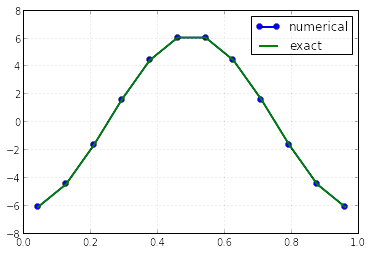

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 12
a, b = 0., 1.
x,dx = np.linspace(a,b,num = Nx, retstep = True, endpoint = False)
x += 0.5*dx

rho = 4*np.pi**2 * np.sin(2*np.pi * x) 

E = Gauss(rho, x, Nx, dx, float(b - a))
E_exact = -2*np.pi*np.cos(2*np.pi*x)

print np.abs(E - E_exact)
print np.max(np.abs(E - E_exact))

plt.plot(x,E, linewidth = 2, marker = 'o', label = 'numerical')
plt.hold('on')
plt.plot(x,E_exact, linewidth = 2, label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

Alternatively, we can use scipy.fftpack

k = 0: xi_0 , xi_0 = 0
k = 1: xi_1 , xi_1 = 6.28319
k = 2: xi_2 , xi_2 = 12.5664
k = 3: xi_3 , xi_3 = 18.8496
k = 4: xi_4 , xi_4 = 25.1327
k = 5: xi_5 , xi_5 = 31.4159
k = 6: xi_6 , xi_6 = 37.6991
k = 7: xi_-5 , xi_-5 = -31.4159
k = 8: xi_-4 , xi_-4 = -25.1327
k = 9: xi_-3 , xi_-3 = -18.8496
k = 10: xi_-2 , xi_-2 = -12.5664
k = 11: xi_-1 , xi_-1 = -6.28319
[  1.77635684e-15   4.44089210e-15   3.55271368e-15   2.66453526e-15
   1.77635684e-15   2.66453526e-15   8.88178420e-16   8.88178420e-16
   1.11022302e-15   8.88178420e-16   3.55271368e-15   3.55271368e-15]
4.4408920985e-15


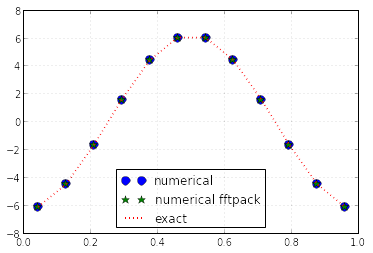

In [32]:
%matplotlib inline
import scipy.fftpack
import numpy as np
import matplotlib.pyplot as plt

# grid setup
Nx = 12
a, b = 0., 1.
x,dx = np.linspace(a,b,num = Nx, retstep = True, endpoint = False)
x += 0.5*dx

rho = 4*np.pi**2 * np.sin(2*np.pi * x) 

E = Gauss(rho, x, Nx, dx, float(b - a))
E_fftpack = scipy.fftpack.diff(rho, -1, Nx*dx)
E_exact = -2*np.pi*np.cos(2*np.pi*x)

print np.abs(E - E_exact)
print np.max(np.abs(E - E_exact))

plt.plot(x,E, markersize = 9, marker = 'o', linestyle = '', label = 'numerical')
plt.hold('on')
plt.plot(x,E_fftpack, markersize = 9, marker = '*', linestyle = '', label = 'numerical fftpack')
plt.plot(x,E_exact, linewidth = 2,  linestyle = ':', label = 'exact')
plt.hold('off')
plt.legend(loc = 'best')
plt.grid('on')

The star markers can be seen inside the (made to be larger sized) circle markers, thus the fftpack agrees with our raw calculation. 

So this checks out fine, actually better than the edge nodes because we capture a better picture of a full period than the edge case which takes an active grid by truncating the grid by one point. Compare with s05 if interested.

# Trigonometric derivative test

Derivatives are taken in Fourier space. We use the definition of the forward transform:

$$f(x) = \sum_{k = -\infty}^{\infty} \mathcal{F}[f](\xi_k) e^{\text{i}\xi_k x}, \quad \xi_k = \frac{2\pi k}{L}$$

where $\text{i} \equiv \sqrt{-1}$. Or, equivalently given the acknowledgement of negative frequencies reproducing the same frequencies as $k \geq N_x / 2$, we can and do choose to write (calculate):

$${}$$
$$ \xi_k =
  \begin{cases}
   2\pi k / L & \text{if } k \leq N_x/2 \\[0.5em]
   2\pi (k - N_x) / L       & \text{else}
  \end{cases}$$
$${}$$

Just as above. We quote <code>numpy.fft</code> documentation to motivate the ordering of wave numbers (frequencies):

<code>
"""
The values in the result follow so-called “standard” order: If A = fft(a, n), then A[0] contains the zero-frequency term (the sum of the signal), which is always purely real for real inputs. Then A[1:n/2] contains the positive-frequency terms, and A[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency
"""
</code>

And, from the above, we have derivative definitions that follow as:

$$f(x) = \sum_{k = -\infty}^{\infty} \mathcal{F}[f](\xi_k) e^{\text{i}\xi_k x} \equiv \mathcal{F}^{-1}\mathcal{F}f$$

$$\frac{d^nf}{dx^n} = \sum_{k = -\infty}^{\infty} (\text{i}\xi_k)^n \mathcal{F}[f](\xi_k) e^{\text{i}\xi_k x} = \mathcal{F}^{-1}[(\text{i}\xi_k)^n\mathcal{F}f]$$

In discrete terms we have at each gridpoint $x_m$,

$$\frac{d^n f(x_m)}{dx^n} \simeq \text{IFFT}[((\text{i}\xi_k)^n\text{FFT}[f]](m)$$



We test this out with the same examples from s25

## Proofing for trigonometric derivatives

We consider the infinitely differentiable function:

$$f(x) = \sin(\pi x) + 1 $$ 

which have derivatives ($n\in\mathbb{N}_1$) :

$$f^{(2n-1)}(x) = (-1)^{n+1} \pi^{2n - 1} \cos(\pi x)$$

and

$$f^{(2n)}(x) = (-1)^n \pi^{2n}\sin(\pi x)$$

Below, we plot the function as well as four normalized derivatives, the normalized derivatives of higher order are coincident with those plotted. Note, this is only to fit them on the same plot, for convergence we properly analyze the unnormalized forms.

the first few derivatives look like the following, where we scale them to put them on the same plot

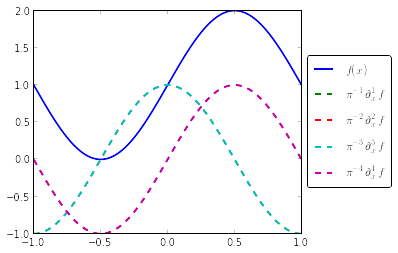

In [9]:
%reload_ext autoreload 
%autoreload 2 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


x, dx = np.linspace(-1,1,num = 1000, retstep = True, endpoint = False)
x += 0.5*dx

f =  np.sin(np.pi*x) + 1
nmax = 4 # maximum derivative desired to be plotted

fig, ax = plt.figure(), plt.subplot(111)

ax.plot(x,f, linewidth = 2, label = '$f(x)$')
ax.hold('on')

for n in range(1,nmax + 1):
    if np.mod(n,2) == 1: # n is odd
        dnf = (-1) ** (n + 1) * np.pi ** (2*n - 1) * np.cos(np.pi * x)
        dnf /= np.pi ** (2*n - 1) # i.e. we plot normalized derivatives

    else: # n is even
        dnf = (-1) ** n * np.pi ** (2*n) * np.sin(np.pi * x)
        dnf /= np.pi ** (2*n) # i.e. we plot normalized derivatives

    ax.plot(x,dnf, linewidth = 2, linestyle = '--', label = r'$\pi^{-%i}\partial_x^{%i} f$' % (n,n) )

ax.hold('off')
frame = ax.get_position() # position of plot center

# shrink frame of the plot to make room for a legend on the right side
ax.set_position([frame.x0, frame.y0, 
                 frame.width * 0.8, frame.height])

# Place legend to the right of the shrunken frame
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, ncol=1)

plt.show()


## first derivative

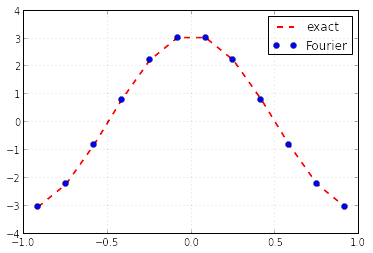

In [8]:
import numpy as np
import matplotlib.pyplot as plt


x, dx = np.linspace(-1,1,num = 12, retstep = True, endpoint = False)
x += 0.5*dx

f =  np.sin(np.pi*x) + 1
n = 1
dnf = (-1) ** (n + 1) * np.pi ** (2*n - 1) * np.cos(np.pi * x)

# IFFT FFT df calc

# setup

Nx = len(x)
L = 1 - (-1.)    
# create wave number vector in same order as return of numpy.fft.fft
xi = np.zeros(Nx)
xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L


Ff = np.fft.fft(f)
Fdf = (1j* xi) ** n * Ff

IFFT_FFT_df = np.real(np.fft.ifft(Fdf))

plt.plot(x, dnf, color = 'red', label = 'exact', lw = 2, linestyle = '--')
plt.hold('on')
plt.plot(x, IFFT_FFT_df, 'ob', label = 'Fourier', lw = 2)
plt.legend(loc = 'best')
plt.grid()
plt.hold('off')
plt.show()

## second derivative

[ 2.55444159  6.9788642   9.53330579  9.53330579  6.9788642   2.55444159
 -2.55444159 -6.9788642  -9.53330579 -9.53330579 -6.9788642  -2.55444159]
[ 2.55444159  6.9788642   9.53330579  9.53330579  6.9788642   2.55444159
 -2.55444159 -6.9788642  -9.53330579 -9.53330579 -6.9788642  -2.55444159]


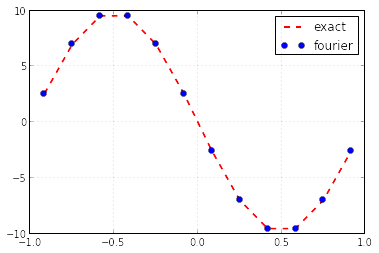

In [74]:
import numpy as np
import matplotlib.pyplot as plt


x, dx = np.linspace(-1,1,num = 12, retstep = True, endpoint = False)
x += 0.5*dx

f =  np.sin(np.pi*x) + 1
n = 2
dnf = - np.pi ** (2) * np.sin(np.pi * x)

# IFFT FFT df calc

# setup

Nx = len(x)
L = 1 - (-1.) 

# create wave number vector in same order as return of numpy.fft.fft
xi = np.zeros(Nx)
xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

Ff = np.fft.fft(f, axis = 0)
Fdf = (1j * xi) ** n * Ff
IFFT_FFT_df = np.real(np.fft.ifft(Fdf, axis = 0))
print IFFT_FFT_df
print dnf
plt.plot(x, dnf, color = 'red', label = 'exact', lw = 2, linestyle = '--')
plt.hold('on')
plt.plot(x, IFFT_FFT_df, 'ob', label = 'fourier', lw = 2)
plt.legend(loc = 'best')
plt.grid()
plt.hold('off')
plt.show()

## fourth derivative

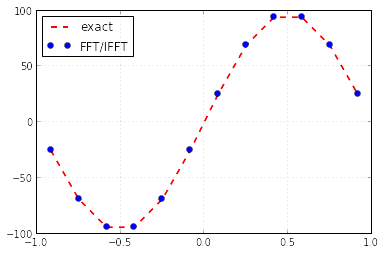

In [15]:
import numpy as np
import matplotlib.pyplot as plt


x, dx = np.linspace(-1,1,num = 12, retstep = True, endpoint = False)
x += 0.5*dx

f =  np.sin(np.pi*x) + 1
n = 4
dnf = (-1) ** n * np.pi ** (n) * np.sin(np.pi * x)

# IFFT FFT df calc

# setup

Nx = len(x)
L = 1 - (-1.)    
# create wave number vector in same order as return of numpy.fft.fft
xi = np.zeros(Nx)
xi[0:Nx/2 + 1] = 2 * np.pi * np.arange(Nx/2 + 1) / L
xi[Nx/2 + 1:] = 2 * np.pi * (np.arange(Nx/2 + 1, Nx) - Nx) / L

Ff = np.fft.fft(f)
Fdf = (1j* xi) ** n * Ff

IFFT_FFT_df = np.real(np.fft.ifft(Fdf))

plt.plot(x, dnf, color = 'red', label = 'exact', lw = 2, linestyle = '--')
plt.hold('on')
plt.plot(x, IFFT_FFT_df, 'ob', label = 'FFT/IFFT', lw = 2)
plt.legend(loc = 'best')
plt.grid()
plt.hold('off')
plt.show()

This also checks out.

Alternatively, we can use scipy.fftpack

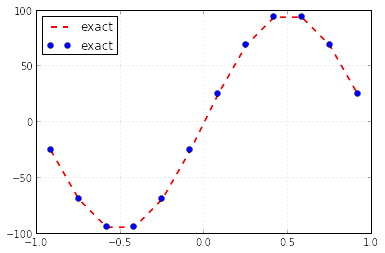

In [16]:
import scipy.fftpack
import numpy as np

Nx = 12
n = 4
x, dx = np.linspace(-1,1,num = Nx, retstep = True, endpoint = False)
x += 0.5*dx

f =  np.sin(np.pi*x) + 1
dnf = (-1) ** n * np.pi ** (n) * np.sin(np.pi * x)

FFT_IFFT_df = scipy.fftpack.diff(f, 4, Nx*dx)
plt.plot(x, dnf, color = 'red', label = 'exact', lw = 2, linestyle = '--')
plt.hold('on')
plt.plot(x, IFFT_FFT_df, 'ob', label = 'exact', lw = 2)
plt.legend(loc = 'best')
plt.grid()
plt.hold('off')
plt.show()